# Project 1

---

## Environment Setup

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(3)

---

## Bank Stock

In this activity, We will use the Alpaca API to grab historical data for RY, TD, BMO, BNS and CM

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
fm_api_key=os.getenv("FM_API_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the bank stocks. Save the results as a pandas DataFrame

In [16]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["RY","TD","BMO","BNS","CM"]

# Set timeframe to '1D'
timeframe = "15Min"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2015-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [54]:
# Display sample data
df.dropna(inplace=True)

---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [55]:
# Calculate the daily roi for the stocks
daily_returns = df.pct_change()

# Display sample data
daily_returns.head()

,BMO,BNS,CM,RY,TD
,close,close,close,close,close
time,,,,,
2015-01-02 09:30:00-05:00,NaN,NaN,NaN,NaN,NaN
2015-01-02 10:00:00-05:00,-0.004808,-0.003717,-0.006860,-0.002027,-0.005064
2015-01-02 10:45:00-05:00,-0.001137,-0.004620,-0.001054,-0.005077,-0.002969
2015-01-02 11:00:00-05:00,-0.001707,-0.003213,-0.002109,-0.002041,-0.001914
2015-01-02 13:30:00-05:00,-0.003990,-0.001612,-0.004110,-0.005113,-0.006607


In [56]:
# Compute daily volatility and avg return 
avg_daily_return_RY = daily_returns.mean()["RY"]["close"]
print (f"Avg daily return of AGG : {avg_daily_return_RY}")

#avg_daily_return_spy = daily_returns.mean()["SPY"]["close"]
#print (f"Avg daily return of SPY : {avg_daily_return_spy}")

std_dev_daily_return_RY = daily_returns.std()["RY"]["close"]
print (f"Daily Std deviation of AGG : {std_dev_daily_return_RY}")

#std_dev_daily_return_spy = daily_returns.std()["SPY"]["close"]
#print (f"Daily Std deviation of SPY : {std_dev_daily_return_spy}")

Avg daily return of AGG : 1.3212279821538121e-05
Daily Std deviation of AGG : 0.0030403783097871237


In [58]:
# Save the last day's closing price
ry_last_price = df["RY"]["close"][-1]
print(ry_last_price)


79.06


In [60]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 126
monte_carlo = pd.DataFrame()
simulated_price_df = pd.DataFrame()

In [64]:
# Run the Monte Carlo Simulation
# Run the simulation of projecting stock prices for the next trading year, `500` times
for n in range(number_simulations):

    # Initialize the simulated prices list with the last closing price of `AGG` and `SPY`
    simulated_ry_prices = [ry_last_price]
    
    # Simulate the returns for 252 * 30 days
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_ry_price = simulated_ry_prices[-1] * (1 + np.random.normal(avg_daily_return_RY, std_dev_daily_return_RY))
        
        # Append the simulated price to the list
        simulated_ry_prices.append(simulated_ry_price)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["RY prices"] = pd.Series(simulated_ry_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (40% AGG; 60% SPY)
    weights = [1]

    # Use the `dot` function with the weights to multiply weights with each column"s simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    monte_carlo[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()


In [65]:
# Check that the simulation ran successfully
monte_carlo.tail()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
122,1.076338,1.069938,0.998729,0.946746,0.997552,0.927633,0.987879,1.030061,1.016762,1.032872,...,0.992844,0.973467,1.010085,0.968983,1.031373,1.026089,1.011552,0.960915,1.026677,1.013355
123,1.071265,1.075544,0.999970,0.944041,0.997864,0.930763,0.990843,1.032469,1.020445,1.022008,...,0.992244,0.971227,1.010550,0.973711,1.033177,1.024669,1.009230,0.960498,1.027481,1.015792
124,1.075306,1.073578,1.004423,0.944449,0.996281,0.934785,0.992159,1.034376,1.016536,1.023973,...,0.997577,0.969853,1.013202,0.972562,1.030990,1.018990,1.013494,0.963302,1.028027,1.013106
125,1.073666,1.069640,1.004329,0.946948,0.995422,0.936964,0.994856,1.032006,1.019940,1.031289,...,1.001517,0.972404,1.012240,0.970624,1.032632,1.023886,1.013313,0.965161,1.027798,1.008677
126,1.071873,1.067996,1.002165,0.944702,0.994012,0.941292,0.994896,1.036105,1.019156,1.034911,...,0.996985,0.972104,1.008652,0.973424,1.030734,1.022356,1.018238,0.966001,1.028106,1.007731


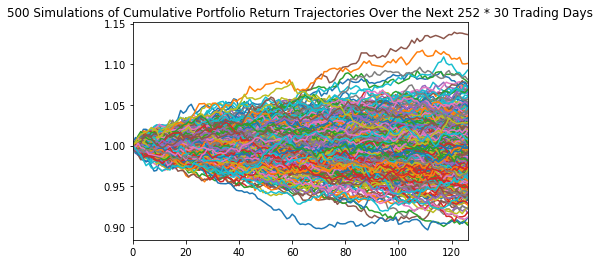

In [66]:
# Visualize the Simulation
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 126 Trading Days"
monte_carlo.plot(legend=None, title=plot_title)

In [67]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns = monte_carlo.iloc[-1, :]
ending_cumulative_returns.head()

0    1.071873
1    1.067996
2    1.002165
3    0.944702
4    0.994012
Name: 126, dtype: float64

In [68]:
# Display the 90% confidence interval for the ending returns
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
print (confidence_interval)

0.05    0.942658
0.95    1.053466
Name: 126, dtype: float64


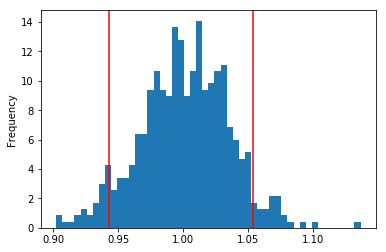

In [69]:
# Visualize the distribution of the ending returns
plt.figure();
ending_cumulative_returns.plot(kind="hist", density=True, bins=50)
plt.axvline(confidence_interval.iloc[0], color="r")
plt.axvline(confidence_interval.iloc[1], color="r")

---

In [39]:
import requests

In [40]:
URL = "https://financialmodelingprep.com/api/v3/financials/income-statement/RY?apikey="f"{fm_api_key}"
r = requests.get(url = URL)
data = r.json() 

In [41]:
data["financials"][0]

{'date': '2018-10-31',
 'Revenue': '32500763358.7786',
 'Revenue Growth': '0.0301085340054',
 'Cost of Revenue': '2042748091.6031',
 'Gross Profit': '30458015267.1756',
 'R&D Expenses': '0.0',
 'SG&A Expense': '14774809160.3053',
 'Operating Expenses': '17429770992.3664',
 'Operating Income': '13028244274.8092',
 'Interest Expense': '0.0',
 'Earnings before Tax': '12006870229.0076',
 'Income Tax Expense': '2541221374.0458',
 'Net Income - Non-Controlling int': '23664122.1374',
 'Net Income - Discontinued ops': '0.0',
 'Net Income': '9465648854.9618',
 'Preferred Dividends': '0.0',
 'Net Income Com': '9465648854.9618',
 'EPS': '6.4046',
 'EPS Diluted': '6.3817',
 'Weighted Average Shs Out': '1109082129.0076',
 'Weighted Average Shs Out (Dil)': '1109082129.0076',
 'Dividend per Share': '2.2359',
 'Gross Margin': '0.9371',
 'EBITDA Margin': '0.2924',
 'EBIT Margin': '0.3694',
 'Profit Margin': '0.2221',
 'Free Cash Flow margin': '0.3639',
 'EBITDA': '12441221374.0458',
 'EBIT': '120068702

In [52]:
URL_TD = "https://financialmodelingprep.com/api/v3/financials/income-statement/BMO?apikey="f"{fm_api_key}"
r_td = requests.get(url = URL_TD)
td_data = r_td.json() 
td_data["financials"][0]

{'date': '2018-10-31',
 'Revenue': '17585496183.2061',
 'Revenue Growth': '0.0183155696385',
 'Cost of Revenue': '0.0',
 'Gross Profit': '17585496183.2061',
 'R&D Expenses': '0.0',
 'SG&A Expense': '8739694656.4885',
 'Operating Expenses': '11423664122.1374',
 'Operating Income': '6161832061.0687',
 'Interest Expense': '0.0',
 'Earnings before Tax': '5656488549.6183',
 'Income Tax Expense': '1496183206.1069',
 'Net Income - Non-Controlling int': '0.0',
 'Net Income - Discontinued ops': '0.0',
 'Net Income': '4160305343.5115',
 'Preferred Dividends': '0.0',
 'Net Income Com': '4160305343.5115',
 'EPS': '6.2519',
 'EPS Diluted': '6.2366',
 'Weighted Average Shs Out': '606119326.7176',
 'Weighted Average Shs Out (Dil)': '606119326.7176',
 'Dividend per Share': '2.2466',
 'Gross Margin': '1.0',
 'EBITDA Margin': '0.2832',
 'EBIT Margin': '0.3217',
 'Profit Margin': '0.1809',
 'Free Cash Flow margin': '0.7391',
 'EBITDA': '6516793893.1298',
 'EBIT': '5656488549.6183',
 'Consolidated Income'

In [4]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SHOP"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2015-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df_shop = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df_shop = df_shop.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [14]:
df_shop.head()


,SHOP
,close
time,
2015-05-21 00:00:00-04:00,25.90
2015-05-22 00:00:00-04:00,28.05
2015-05-26 00:00:00-04:00,29.71
2015-05-27 00:00:00-04:00,27.66
2015-05-28 00:00:00-04:00,27.49


In [6]:
import pyfolio as pf
%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings('ignore')

In [9]:
pf.create_returns_tear_sheet(df_shop)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().